In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os
import torch as pt
from tqdm import tqdm

# Add the project root
sys.path.append(os.path.abspath('../../'))

from src.useful_functions import read_dirs_paths
from src.isokann.modules import *

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# For reproducibility
np.random.seed(0)
pt.manual_seed(0)

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print("")
print(device)


Created variables:
inp_dir = input/
out_trajectories1 = output/trajectories/
out_trajectories2 = output/trajectories/openmm_files/
out_trajectories3 = output/trajectories/openmm_files/initial_states/
out_trajectories4 = output/trajectories/openmm_files/final_states/
out_isokann = output/isokann/
out_mokito = output/mokito/

cuda


In [2]:
# Load initial and final states and convert to torch
D0 = pt.load(out_trajectories1 + 'BAT_0.pt', map_location=device)
DT = pt.load(out_trajectories1 + 'BAT_t.pt', map_location=device)
R0 = np.loadtxt(out_trajectories1 + 'R0.txt')

Npoints = D0.shape[0]
Ndims   = D0.shape[1]

Nfinpoints  = DT.shape[1]
Nframes     = DT.shape[3]


frame = 9
Dt = pt.clone(DT[frame,:,:,:])

In [3]:

# Find the optimal hyperparameters using random search
NN_layers =          [(Ndims, int(2*Ndims/3), 1), 
                      (Ndims, int(Ndims/2), 1), 
                      (Ndims, int(Ndims/3), 1)]


learning_rates = [0.01, 
                  0.001, 
                  0.0001]

weight_decays = [0.001, 0.0001, 0.00001]

best_hyperparams, best_val_loss = random_search(D0, Dt, 
                                                NN_layers, 
                                                learning_rates, 
                                                weight_decays, 
                                                batch_size = 200,
                                                search_iterations=20)

print(" ")
print("The best hyperparameters are:", best_hyperparams)
print("The best validation loss is:",  best_val_loss)
print(" ")


  0%|          | 0/20 [00:00<?, ?it/s]

Testing learning rate = 0.001
Testing weight decays = 1e-05
Testing layers = [1716  572    1]
Validation loss: 

  5%|▌         | 1/20 [00:23<07:23, 23.35s/it]

tensor(0.0008, device='cuda:0')
Testing learning rate = 0.001
Testing weight decays = 1e-05
Testing layers = [1716  858    1]


 10%|█         | 2/20 [00:39<05:38, 18.83s/it]

Validation loss: tensor(0.0018, device='cuda:0')
Testing learning rate = 0.0001
Testing weight decays = 0.0001
Testing layers = [1716  572    1]


 15%|█▌        | 3/20 [00:55<05:03, 17.85s/it]

Validation loss: tensor(0.0004, device='cuda:0')
Testing learning rate = 0.01
Testing weight decays = 0.001
Testing layers = [1716 1144    1]


 20%|██        | 4/20 [01:11<04:32, 17.01s/it]

Validation loss: tensor(0.0036, device='cuda:0')
Testing learning rate = 0.001
Testing weight decays = 1e-05
Testing layers = [1716 1144    1]


 25%|██▌       | 5/20 [01:26<04:07, 16.48s/it]

Validation loss: tensor(0.0015, device='cuda:0')
Testing learning rate = 0.01
Testing weight decays = 0.001
Testing layers = [1716  572    1]


 30%|███       | 6/20 [01:43<03:50, 16.46s/it]

Validation loss: tensor(0.0027, device='cuda:0')
Testing learning rate = 0.0001
Testing weight decays = 1e-05
Testing layers = [1716 1144    1]


 35%|███▌      | 7/20 [01:59<03:32, 16.37s/it]

Validation loss: tensor(0.0004, device='cuda:0')
Testing learning rate = 0.01
Testing weight decays = 1e-05
Testing layers = [1716  572    1]


 40%|████      | 8/20 [02:15<03:16, 16.37s/it]

Validation loss: tensor(0.0124, device='cuda:0')
Testing learning rate = 0.001
Testing weight decays = 0.0001
Testing layers = [1716  858    1]


 45%|████▌     | 9/20 [02:31<02:55, 15.96s/it]

Validation loss: tensor(0.0010, device='cuda:0')
Testing learning rate = 0.001
Testing weight decays = 1e-05
Testing layers = [1716  858    1]


 50%|█████     | 10/20 [02:47<02:41, 16.18s/it]

Validation loss: tensor(0.0008, device='cuda:0')
Testing learning rate = 0.001
Testing weight decays = 0.001
Testing layers = [1716 1144    1]


 55%|█████▌    | 11/20 [03:02<02:22, 15.86s/it]

Validation loss: tensor(0.0009, device='cuda:0')
Testing learning rate = 0.0001
Testing weight decays = 1e-05
Testing layers = [1716  858    1]


 60%|██████    | 12/20 [03:19<02:08, 16.02s/it]

Validation loss: tensor(0.0005, device='cuda:0')
Testing learning rate = 0.001
Testing weight decays = 0.0001
Testing layers = [1716 1144    1]


 65%|██████▌   | 13/20 [03:34<01:50, 15.84s/it]

Validation loss: tensor(0.0008, device='cuda:0')
Testing learning rate = 0.0001
Testing weight decays = 0.0001
Testing layers = [1716  858    1]


 70%|███████   | 14/20 [03:51<01:36, 16.13s/it]

Validation loss: tensor(0.0005, device='cuda:0')
Testing learning rate = 0.001
Testing weight decays = 0.0001
Testing layers = [1716  858    1]


 75%|███████▌  | 15/20 [04:06<01:19, 15.95s/it]

Validation loss: tensor(0.0021, device='cuda:0')
Testing learning rate = 0.001
Testing weight decays = 0.0001
Testing layers = [1716  572    1]


 80%|████████  | 16/20 [04:23<01:04, 16.12s/it]

Validation loss: tensor(0.0009, device='cuda:0')
Testing learning rate = 0.0001
Testing weight decays = 0.001
Testing layers = [1716  572    1]


 85%|████████▌ | 17/20 [04:38<00:47, 15.71s/it]

Validation loss: tensor(0.0004, device='cuda:0')
Testing learning rate = 0.0001
Testing weight decays = 0.0001
Testing layers = [1716 1144    1]


 90%|█████████ | 18/20 [04:53<00:30, 15.43s/it]

Validation loss: tensor(0.0003, device='cuda:0')
Testing learning rate = 0.01
Testing weight decays = 1e-05
Testing layers = [1716 1144    1]


 95%|█████████▌| 19/20 [05:08<00:15, 15.56s/it]

Validation loss: tensor(0.0034, device='cuda:0')
Testing learning rate = 0.01
Testing weight decays = 1e-05
Testing layers = [1716  572    1]


100%|██████████| 20/20 [05:25<00:00, 16.27s/it]

Validation loss: tensor(0.0029, device='cuda:0')
 
The best hyperparameters are: {'nodes': array([1716, 1144,    1]), 'learning_rate': 0.0001, 'weight_decay': 0.0001}
The best validation loss is: tensor(0.0003, device='cuda:0')
 


In [4]:
NNnodes =  (Ndims, int(Ndims/3), 1) # best_hyperparams['nodes']
print("FNN layers:", NNnodes)

lr      = best_hyperparams['learning_rate'] 
print("lr = ", lr)

wd = best_hyperparams['weight_decay']
print("wd = ", wd)

np.savetxt(out_isokann + 'NNnodes.txt', NNnodes)

# Define the interpolating function
f_NN = NeuralNetwork( Nodes = np.asarray(NNnodes) ).to(device)

# Apply the power method using the best hyperparameters
train_LOSS, val_LOSS, best_loss = power_method(D0, Dt, 
                                               f_NN, 
                                               scale_and_shift, 
                                               Niters = 200, 
                                               Nepochs = 10,
                                               tolerance  = 5e-4, 
                                               lr = lr*10,
                                               wd=wd,
                                               batch_size = 1000,  
                                               print_eta  = True
                                              )

FNN layers: (1716, 572, 1)
lr =  0.0001
wd =  0.0001


100%|██████████| 200/200 [00:08<00:00, 24.40it/s]


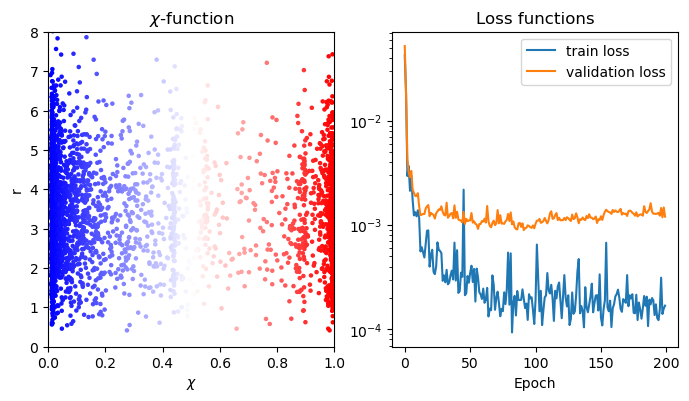

In [5]:
npX0 = D0.cpu().detach().numpy()
chi  = f_NN(D0).cpu().detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(16*in2cm, 8*in2cm), facecolor='white')


pos = ax[0].scatter( chi, R0, c = chi,  cmap = cm.bwr , s = 5 )

ax[0].set_title('$\chi$-function')
ax[0].set_xlim((0,1))
ax[0].set_ylim(0,8)
ax[0].set_ylabel('r')
ax[0].set_xlabel(r'$\chi$')


ax[1].plot(train_LOSS, label='train loss')
ax[1].plot(val_LOSS, label='validation loss')
ax[1].semilogy()
ax[1].set_xlabel('Epoch')
ax[1].set_title('Loss functions')
ax[1].legend()

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.5)
#fig.savefig('chi.png', format='png', dpi=900, bbox_inches='tight')

In [6]:
pt.save(f_NN.state_dict(), out_isokann  + 'f_NN_.pt')
np.savetxt(out_isokann  + 'val_LOSS_.txt', val_LOSS)
np.savetxt(out_isokann  + 'train_LOSS_.txt', train_LOSS)
np.savetxt(out_isokann + 'chi0_.txt', chi)

# Calculate propagated chi
#chit = f_NN(Xtau).cpu().detach().numpy()
#np.save(out_isokann + 'chit.npy', chit)
